<a href="https://colab.research.google.com/github/swilsonmfc/bayesian/blob/main/Uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty

# Install

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf

import arviz as az
import pymc3 as pm
from pymc3 import Model
from pymc3 import sample
from pymc3 import traceplot
from pymc3 import plot_posterior_predictive_glm
from pymc3.glm import GLM

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Utils

In [3]:
def abline(slope, intercept, linestyle='--', color='red'):
    ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle, color=color)

# Data

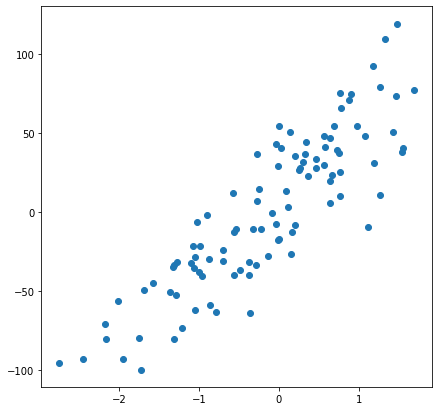

In [4]:
X, y = make_regression(n_samples=100, n_features=1, bias=1, noise=25, random_state=1337)
plt.figure(figsize=(7, 7))
plt.scatter(X, y);

# Linear Regression

## OLS
* Ordinary Least Squares

In [5]:
lm = LinearRegression()
lm.fit(X, y)
print(f'Model: y = {lm.coef_} X + {lm.intercept_}')

Model: y = [42.0003695] X + 6.961808867897723


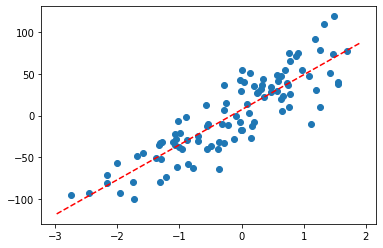

In [6]:
plt.scatter(X, y)
abline(lm.coef_[0], lm.intercept_)

X = 1, Y = 48.96217836358758


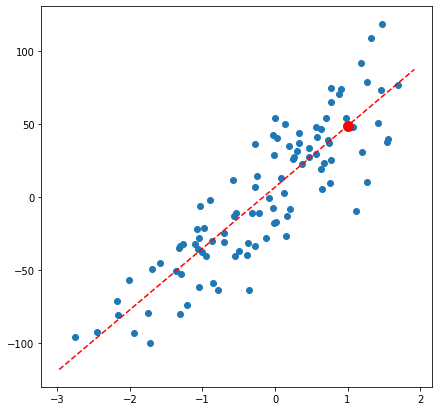

In [7]:
pred_x = [[1]]
pred_y = lm.predict(pred_x)[0]
print(f'X = 1, Y = {pred_y}')

plt.figure(figsize=(7, 7))
plt.scatter(X, y)
abline(lm.coef_[0], lm.intercept_)
plt.scatter(pred_x, pred_y, color='red', marker='o', linewidth=5);

## StatsModels

In [8]:
mod = sm.OLS.from_formula('y ~ X', {'y': y, 'X': X})
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     313.6
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           2.67e-32
Time:                        14:30:05   Log-Likelihood:                -458.70
No. Observations:                 100   AIC:                             921.4
Df Residuals:                      98   BIC:                             926.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9618      2.428      2.867      0.0

## Confidence & Prediction Intervals
* A confidence interval is the range that contains the likely mean value of the dependent variable given specific values of the independent variables. Note, this is the likely range in the long run of repeated experiments.  Like a regular confidence interval, these intervals offer a range for the population average, but aren't informative about the spread of an individual data point.
* A prediction interval in contrast to a confidence interval is the likely range that contains the value of the dependent variable for a single new observation given specific values of the independent variables. Here we predict a range for an individual observations rather than the mean value of repeated experiments.



In [9]:
predictions = res.get_prediction({'X':[1]})
frame = predictions.summary_frame()
frame

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,48.962178,3.641635,41.735472,56.188885,0.78395,97.140407


X = 1, Y = 48.96217836358758


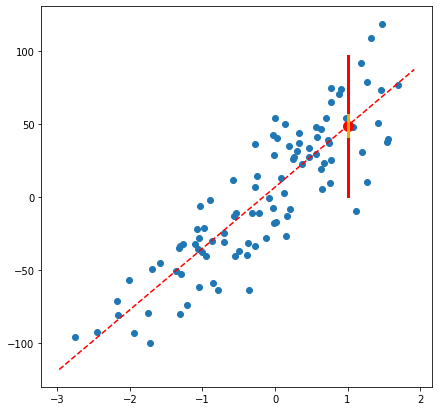

In [10]:
pred_x = [[1]]
pred_y = lm.predict(pred_x)[0]
print(f'X = 1, Y = {pred_y}')

plt.figure(figsize=(7, 7))
plt.scatter(X, y)
abline(lm.coef_[0], lm.intercept_)
plt.scatter(pred_x, pred_y, color='red', marker='o', linewidth=5);

plt.plot((1, 1), (frame.loc[0]['obs_ci_lower'], frame.loc[0]['obs_ci_upper']), 
         color='red', linewidth=3)
plt.plot((1, 1), 
         (frame.loc[0]['mean_ci_lower'], frame.loc[0]['mean_ci_upper']), 
         color='orange', linewidth=3)

## Quantiles

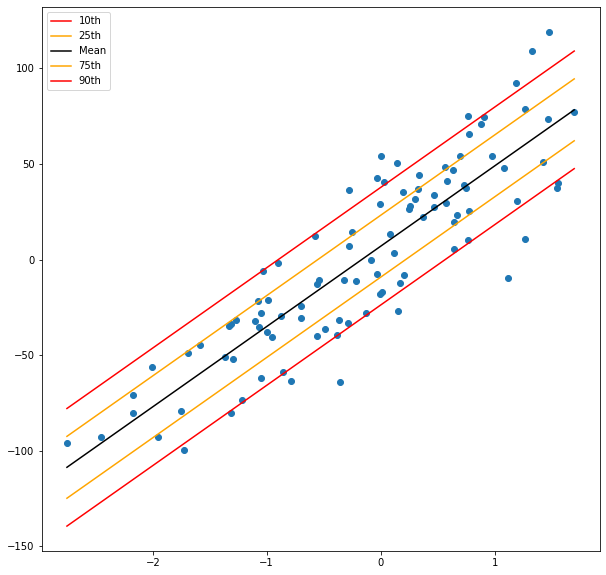

In [11]:
quantiles = [.10, .25, .50, .75, .90]
colors    = ['red', 'orange', 'black', 'orange', 'red']
labels    = ['10th', '25th', 'Mean', '75th', '90th']
x_plot    = np.linspace(min(X), max(X))

plt.figure(figsize=(10, 10))
for q, c, label in zip(quantiles, colors, labels):
  y_plot = res.predict({'X':x_plot}) + norm.ppf(q) * np.sqrt(res.scale)
  plt.plot(x_plot, y_plot, label=label, color=c)
plt.scatter(X, y)
plt.legend()  

# Quantile Regression
* OLS is widely used, but as a parametric model, it relies on assumptions that are often not met. 
* Quantile regression does not make assumptions about the residuals and their distribution.  (It will also be more rubust to outliers)
* You can use the estimates for different percentiles to help identify likely ranges for predictions.

## StatsModels
* https://www.statsmodels.org/stable/examples/notebooks/generated/quantile_regression.html#Setup

In [12]:
mod = smf.quantreg('y ~ X', {'y': y, 'X': X})
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.5345
Model:                       QuantReg   Bandwidth:                       28.99
Method:                 Least Squares   Sparsity:                        71.80
Date:                Thu, 03 Dec 2020   No. Observations:                  100
Time:                        14:30:05   Df Residuals:                       98
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5617      3.632      2.357      0.020       1.355      15.769
X             40.9836      3.548     11.552      0.000      33.943      48.024


In [13]:
predictions = res.get_prediction({'X':[1]})
predictions.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,49.545287,5.446789,38.736311,60.354262,38.555653,60.534921


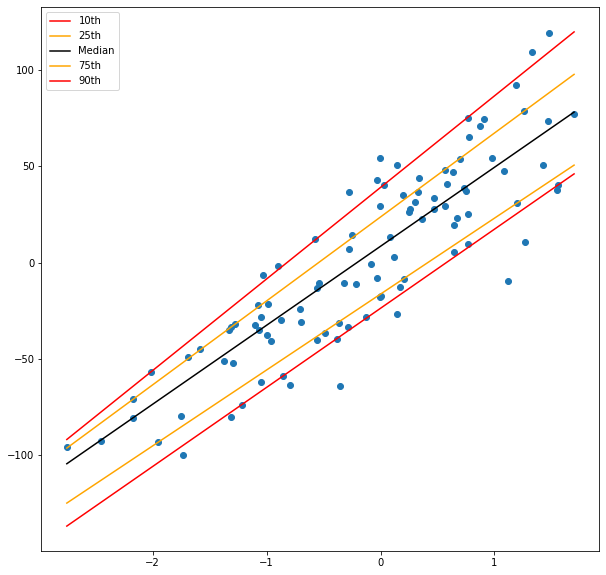

In [14]:
quantiles = [.10, .25, .50, .75, .90]
colors    = ['red', 'orange', 'black', 'orange', 'red']
labels    = ['10th', '25th', 'Median', '75th', '90th']
x_plot    = np.linspace(min(X), max(X))

plt.figure(figsize=(10, 10))
for q, c, label in zip(quantiles, colors, labels):
  res = mod.fit(q=q)
  y_plot = res.predict({'X':x_plot})
  plt.plot(x_plot, y_plot, label=label, color=c)
plt.scatter(X, y)
plt.legend()  

# RandomForests

![](https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png)

## Quantiles
* To extract quantiles from a random forest, we poll each tree individually 
* We then pull the desired quantile from the estimations

In [15]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
def rf_quantile(rf, X, quantile):
  rf_preds = []
  for estimator in rf.estimators_:
    rf_preds.append(estimator.predict(X))
  rf_preds = np.array(rf_preds).transpose()
  return np.percentile(rf_preds, quantile, axis=1)

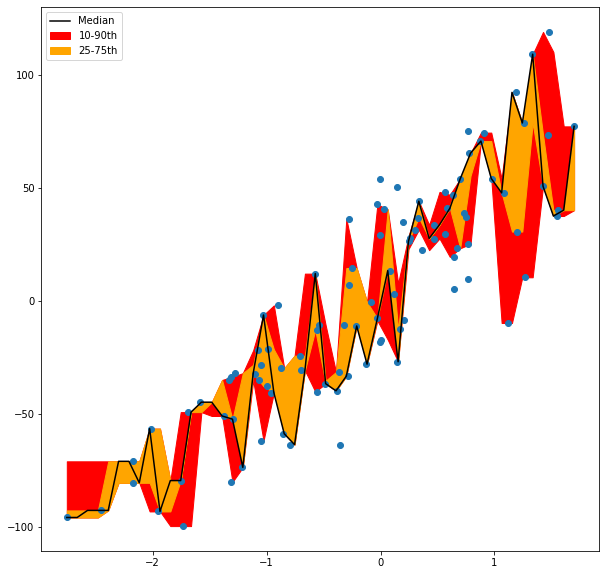

In [17]:
x_plot    = np.linspace(min(X), max(X))
plt.figure(figsize=(10, 10))
y_plot_10 = rf_quantile(rf, x_plot, [10]).T.squeeze()
y_plot_25 = rf_quantile(rf, x_plot, [25]).T.squeeze()
y_plot_50 = rf_quantile(rf, x_plot, [50]).T.squeeze()
y_plot_75 = rf_quantile(rf, x_plot, [75]).T.squeeze()
y_plot_90 = rf_quantile(rf, x_plot, [90]).T.squeeze()
plt.fill_between(x_plot.squeeze(), y_plot_10, y_plot_90, color='red', label='10-90th')
plt.fill_between(x_plot.squeeze(), y_plot_25, y_plot_75, color='orange', label='25-75th')
plt.plot(x_plot, y_plot_50, label='Median', color='black')
plt.scatter(X, y)
plt.legend()  

## Softmax

In [18]:
y_bin = pd.cut(y, bins=[-999, -50, -25, 0, 25, 50, 999])
encoder = LabelEncoder()
y_coded = encoder.fit_transform(y_bin)

X_train, X_test, y_train, y_test, _, y_test_act = train_test_split(X, y_coded, y)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
labels = [f'{c}' for c in y_bin.categories]
pred = rf.predict(X_test)
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

 (-999, -50]       0.71      0.83      0.77         6
  (-50, -25]       0.25      0.20      0.22         5
    (-25, 0]       0.00      0.00      0.00         3
     (0, 25]       0.17      0.33      0.22         3
    (25, 50]       0.75      0.60      0.67         5
   (50, 999]       0.50      0.33      0.40         3

    accuracy                           0.44        25
   macro avg       0.40      0.38      0.38        25
weighted avg       0.45      0.44      0.44        25



In [20]:
pred = rf.predict_proba(X_test)
pred_df = pd.DataFrame(pred)
pred_df.columns = labels
pred_df['Actual'] = y_test_act
pred_df.head()

,"(-999, -50]","(-50, -25]","(-25, 0]","(0, 25]","(25, 50]","(50, 999]",Actual
0,0.00,0.00,0.00,0.69,0.19,0.12,38.989424
1,0.00,0.00,0.00,0.39,0.61,0.00,41.029954
2,0.61,0.24,0.15,0.00,0.00,0.00,-63.523356
3,0.94,0.06,0.00,0.00,0.00,0.00,-93.080429
4,0.04,0.34,0.62,0.00,0.00,0.00,-32.057021


# Confidence Intervals

* A 89% confidence interval means that if we were to take 100 samples and compute the 89% confidence interval for each sample, then approximately 89% of the 100 confidence intervals will contain the true mean value.  
*  A single confidence interval does not represent a 89% chance that true value exists in the interval, but rather in the long run, 89% of the sample intervals will have the value (the frequentist view here is not really satisfying)
* What we often want is a range estimate that contains a particular percentage of probable values.  In bayesian inference we call that a credible interval.  For example, an 89% credible interval is simply the central portion of the posterior distribution that contains 89% of the values.

# Bayesian Inference

![](https://i.pinimg.com/originals/5d/90/79/5d9079798db012ca2af8806d7d211fdf.png)

In [21]:
data = {'x': X, 'y':y}
with Model() as model:
    GLM.from_formula('y ~ x', data)
    trace = sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:07<00:00, 956.75draws/s]


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

<Figure size 504x504 with 0 Axes>

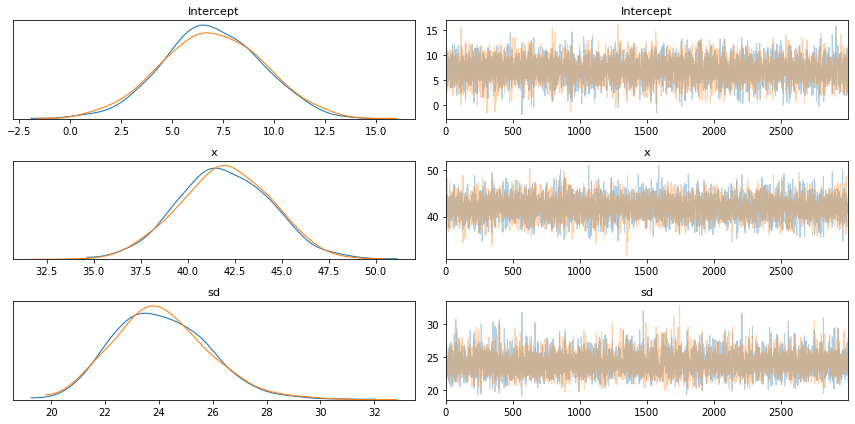

In [22]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

In [23]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,6.971,2.466,2.592,11.877,0.030,0.023,6597.0,5998.0,6593.0,4275.0,1.0
x,41.991,2.440,37.290,46.295,0.029,0.021,7041.0,6998.0,7041.0,4753.0,1.0
sd,24.100,1.763,20.932,27.309,0.021,0.015,7368.0,7236.0,7471.0,4293.0,1.0


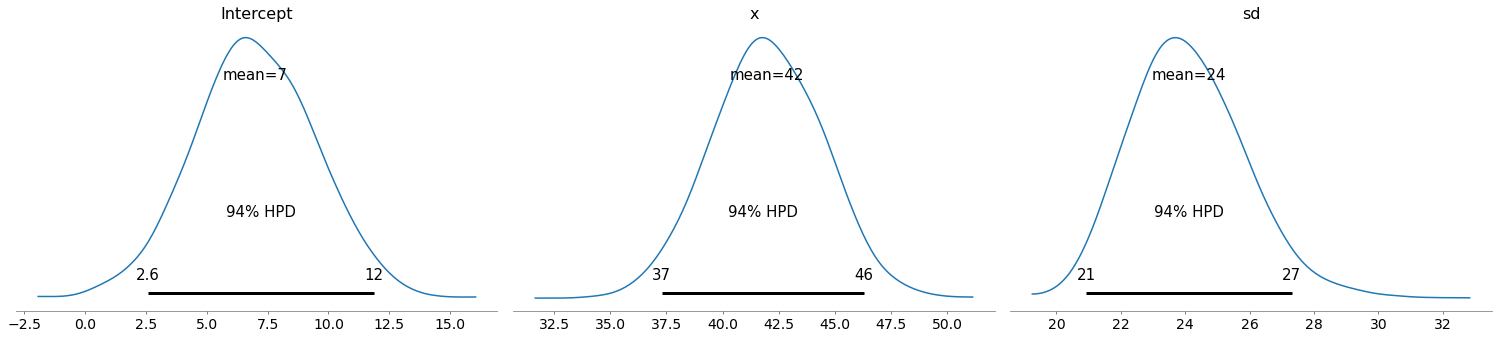

In [24]:
pm.plot_posterior(trace)
plt.show()

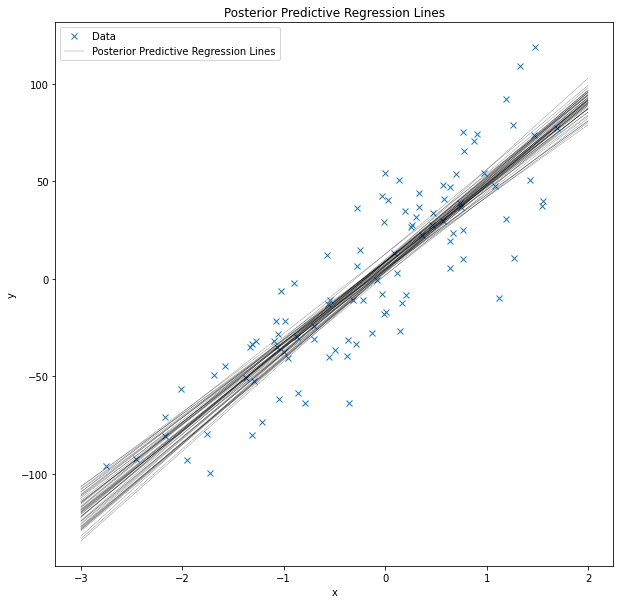

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(X, y, 'x', label='Data')
plot_posterior_predictive_glm(trace, samples=50, eval=np.linspace(-3, 2), 
                              label='Posterior Predictive Regression Lines')
plt.title('Posterior Predictive Regression Lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

# TensorFlow Probability

## Loss Function
* Negative Log Likelihood
* Negative: We're minimizing not maximizing
* Log: Numerically stable
* log(a*b) = log(a) + log(b)
* Likelihood: Chances that calculated parameters produced observed data

In [26]:
neg_log_likelihood = lambda y, rv_y: -rv_y.log_prob(y)

## Model - No Uncertainy
* Output our coefficient from a Neural Network
* Use it's bias in our model
* Assume that the location can move, but have an exact scale

In [27]:
model = Sequential()
model.add(Dense(1))
model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))
model.compile(optimizer=Adam(learning_rate=0.01), loss=neg_log_likelihood)
history = model.fit(X, y, epochs=500, verbose=False)

In [28]:
y_hat = model(X)
m = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())
print(f'y = ({m}) X + {b}')

y = (17.631967544555664) X + 1.4491456747055054


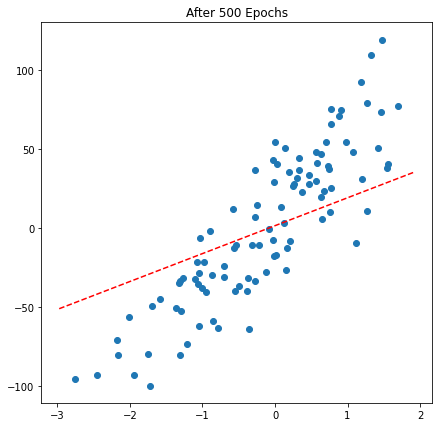

In [29]:
plt.figure(figsize=(7, 7))
plt.scatter(X, y)
abline(m, b)
plt.title('After 500 Epochs');

In [30]:
history = model.fit(X, y, epochs=1500, verbose=False)

In [31]:
y_hat = model(X)
m = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())
print(f'y = ({m}) X + {b}')

y = (41.78898239135742) X + 6.996014595031738


Text(0.5, 1.0, 'After 2000 Epochs')

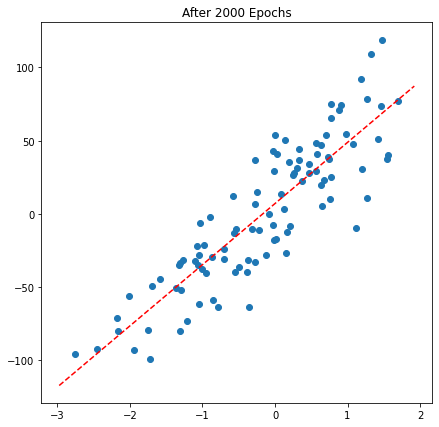

In [32]:
plt.figure(figsize=(7, 7))
plt.scatter(X, y)
abline(m, b)
plt.title('After 2000 Epochs')

## Model - Uncertainty
* Model both the coefficient
* Allow our estimates of location and scale to adjust

In [33]:
model = Sequential()
model.add(Dense(2))
model.add(tfp.layers.DistributionLambda(lambda t: 
                                        tfd.Normal(loc=t[..., :1],
                                        scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))))
model.compile(optimizer=Adam(learning_rate=0.01), loss=neg_log_likelihood)
history = model.fit(X, y, epochs=500, verbose=False)


In [34]:
y_hat = model(X)
m = y_hat.mean()
s = y_hat.stddev()
[print(np.squeeze(w.numpy())) for w in model.weights]

[14.265949  -1.6749442]
[ 3.4442182 13.07141  ]


[None, None]

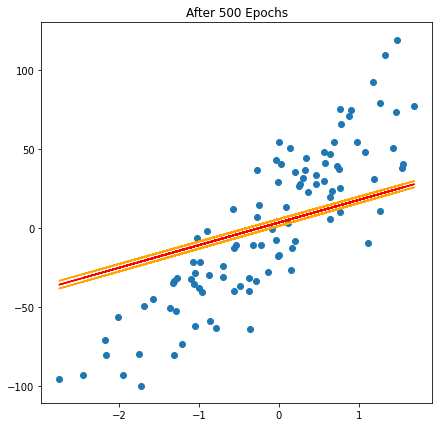

In [35]:
plt.figure(figsize=(7, 7))
plt.scatter(X, y)
plt.plot(X, m, color='red')
plt.plot(X, m + 2 * s, 'orange')
plt.plot(X, m - 2 * s, 'orange')
plt.title('After 500 Epochs');

In [36]:
history = model.fit(X, y, epochs=1500, verbose=False)

In [37]:
y_hat = model(X)
m = y_hat.mean()
s = y_hat.stddev()
[print(np.squeeze(w.numpy())) for w in model.weights]

[38.612904   1.7586038]
[ 5.8398433 38.242157 ]


[None, None]

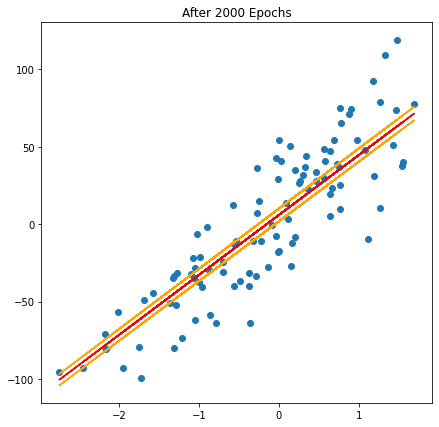

In [38]:
plt.figure(figsize=(7, 7))
plt.scatter(X, y)
plt.plot(X, m, color='red')
plt.plot(X, m + 2 * s, 'orange')
plt.plot(X, m - 2 * s, 'orange')
plt.title('After 2000 Epochs');